In [1]:
# Standard libraries
import xarray as xr
import numpy as np
import pandas as pd
# import os
# from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import iris
from iris.pandas import as_cubes
import sys
import math
import os
import glob

from datetime import datetime
from cartopy.util import add_cyclic_point
import gc
import imageio.v2
from IPython import display
# import netCDF4
from global_land_mask import globe
# # Import tobac itself:
import tobac

# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [2]:
%%time
path = '/glade/u/home/noteng/work/research/data/'
file = 'march13-march14.nc'
data = xr.open_dataset(path+file)
data = data.sel(time=slice('2020-03-13T04:00:00.000000000', '2020-03-14T05:00:00.000000000'))
data.close()

CPU times: user 22.1 ms, sys: 15 ms, total: 37.1 ms
Wall time: 138 ms


In [3]:
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,450:580,256:771] #Based on longitude and latitude of Andoya and Norwegian Sea
equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,250:650,450:850] #Based on longitude and latitude of Andoya and Norwegian Sea
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,330:580,660:780] #### hdm1 and hdm2
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor']
equivalent_reflectivity_factor

<xarray.DataArray 'equivalent_reflectivity_factor' (time: 301, Yc: 400, Xc: 400)>
[48160000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14T05:00:00
  * Xc       (Xc) float32 -8.3e+04 -8.2e+04 -8.1e+04 ... 3.15e+05 3.16e+05
  * Yc       (Yc) float32 -2.06e+06 -2.061e+06 ... -2.458e+06 -2.459e+06
    lon      (Yc, Xc) float32 ...
    lat      (Yc, Xc) float32 ...
Attributes:
    standard_name:  equivalent_reflectivity_factor
    long_name:      Radar Reflectivity
    units:          dBZ
    grid_mapping:   projection_lambert

In [4]:
# load Mask_ERF_files
Mask_ERF = iris.load('../saved-files/threshold-all/Mask_ERF_iris-all.nc')[0]
Mask_ERF

<iris 'Cube' of segmentation_mask / (1) (time: 301; -- : 400; -- : 400)>

In [5]:
track = pd.read_csv('../saved-files/threshold-all/track-reset-all.csv')
track

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
0,0,1,84.600598,399.000000,4,10,1,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.144601e+06,316000.000000,70.490523,18.382036,1,0 days 00:00:00
1,0,2,101.255095,389.000000,5,10,2,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.161255e+06,306000.000000,70.353605,18.058626,2,0 days 00:00:00
2,1,2,104.000000,390.000000,1,10,154,2020-03-13 04:05:00,2020-03-13 04:05:00,-2.164000e+06,307000.000000,70.327606,18.074493,2,0 days 00:05:00
3,0,4,112.472423,381.827530,14,10,3,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.172472e+06,298827.530189,70.261556,17.831991,3,0 days 00:00:00
4,1,4,113.727184,383.443874,16,10,155,2020-03-13 04:05:00,2020-03-13 04:05:00,-2.173727e+06,300443.873660,70.248236,17.869335,3,0 days 00:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35549,300,71,281.407469,341.801921,7,15,35528,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.341407e+06,258801.920735,68.779128,16.307449,12343,0 days 00:00:00
35550,300,72,284.000000,349.225721,3,15,35529,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.344000e+06,266225.720790,68.748089,16.479746,12344,0 days 00:00:00
35551,300,89,213.928276,182.828784,14,20,35543,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.273928e+06,99828.783967,69.504222,12.513754,12345,0 days 00:00:00
35552,300,97,272.389563,284.000000,2,20,35551,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.332390e+06,201000.000000,68.912575,14.925450,12346,0 days 00:00:00


In [6]:
# # Changing time cell to timedelta
# time_cell = track['time_cell'].astype('timedelta64[ns]').values
# time_cell

### CALCULATING FOR DISTANCE

In [7]:
distance = []
for i in range(len(track)):
    lat_andenes = 69.141599 # latitude of Andenes
    #lat_andenes = 69.2412 # latiude of the radar
    lon_andenes = 15.684104 # latitude of Andenes
    # lon_andenes = 16.0030 # longitude of where the radar is located
    
# 69.2412° N, 16.0030° E
    
    distances = tobac.analysis.haversine(track['latitude'][i], track['longitude'][i], lat_andenes, lon_andenes)
    distance.append(distances)

In [8]:
distance[:10]
# np.max(distance)

[182.4061549695696,
 162.99137822765474,
 160.98606513865352,
 149.72248345918496,
 149.3151648172964,
 149.2139703150614,
 148.58484315590556,
 147.91223348059512,
 141.3846314516514,
 139.95070287050123]

In [9]:
%%time
# apped distance to track dataframe
track['distance'] = pd.Series(distance)

CPU times: user 4.56 ms, sys: 0 ns, total: 4.56 ms
Wall time: 4.56 ms


In [10]:
track.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
0,0,1,84.600598,399.000000,4,10,1,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.144601e+06,316000.000000,70.490523,18.382036,1,0 days 00:00:00,182.406155
1,0,2,101.255095,389.000000,5,10,2,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.161255e+06,306000.000000,70.353605,18.058626,2,0 days 00:00:00,162.991378
2,1,2,104.000000,390.000000,1,10,154,2020-03-13 04:05:00,2020-03-13 04:05:00,-2.164000e+06,307000.000000,70.327606,18.074493,2,0 days 00:05:00,160.986065
3,0,4,112.472423,381.827530,14,10,3,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.172472e+06,298827.530189,70.261556,17.831991,3,0 days 00:00:00,149.722483
4,1,4,113.727184,383.443874,16,10,155,2020-03-13 04:05:00,2020-03-13 04:05:00,-2.173727e+06,300443.873660,70.248236,17.869335,3,0 days 00:05:00,149.315165


## _cells that lived for at least 10 mins old_ 

In [11]:
%%time
# cell_one_hour = np.timedelta64( 600, 's') #10 minutes in seconds
cell_times = np.timedelta64( 600, 's') #10 minutes in seconds

#convert time_cell to seconds
time_cell = track['time_cell'].astype('timedelta64[ns]').values

# track cell that live for at least 10 minutes long
# track_close_to_AMF1 = track[ time_cell >= cell_times ]
track_close_to_AMF1 = track[ (time_cell >= cell_times) & (track['distance'] <= 20) ]
# track_close_to_AMF1 = track[ ((track['distance'] <= 95) & (track['time_cell'].values >= cell_one_hour)) ]
track_close_to_AMF1= track_close_to_AMF1.drop_duplicates(subset=['cell']) # remove duplicates of cell_ids
track_close_to_AMF1.head()

CPU times: user 66.2 ms, sys: 868 µs, total: 67.1 ms
Wall time: 69.4 ms


,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
542,4,45,252.997935,318.049114,31,10,636,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,300,0 days 00:10:00,10.269203
1025,6,47,263.000000,310.000000,1,10,952,2020-03-13 04:30:00,2020-03-13 04:30:00,-2.323000e+06,227000.000000,68.976128,15.581136,484,0 days 00:10:00,18.869849
1153,10,51,244.323857,292.386688,8,10,1595,2020-03-13 04:50:00,2020-03-13 04:50:00,-2.304324e+06,209386.687718,69.160704,15.192030,527,0 days 00:25:00,19.610700
2400,14,154,238.164707,322.864324,5,15,2334,2020-03-13 05:10:00,2020-03-13 05:10:00,-2.298165e+06,239864.323620,69.189591,15.958508,975,0 days 00:10:00,12.106666
2656,16,164,257.961832,313.409819,5,15,2700,2020-03-13 05:20:00,2020-03-13 05:20:00,-2.317962e+06,230409.818658,69.018791,15.676662,1075,0 days 00:10:00,13.673788


In [12]:
# total track cells found.
len(track_close_to_AMF1) 

73

# tracking all cells that were at least 10 minutes old back in time to get all the cells

In [13]:
%%time
combined_tracks_AMF1 = []
for index, cell_id in enumerate(np.unique(track_close_to_AMF1['cell'].values)): # looped through tracks found with AMF1 site
    if cell_id in track['cell']: # checking if those cells(tracks) are within the original tracked dataframe
        track_i = track[track['cell'] == cell_id] # display it if it is within the tracked dataframe
        combined_tracks_AMF1.append(track_i) # append the results you get a new dataFrame calld combined_tracks_AMF1

# Concatenate the dataframes(combined_tracks_AMD) along the rows axis with keys
# tracks_closer_AMF1 = pd.concat(combined_tracks_AMF1, keys=['df1', 'df2', 'df3', 'df4', 'df5', 'df6'])
tracks_closer_AMF1 = pd.concat(combined_tracks_AMF1)
tracks_closer_AMF1

CPU times: user 28.3 ms, sys: 46 µs, total: 28.3 ms
Wall time: 28.3 ms


,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
540,2,45,246.000000,316.000000,1,10,338,2020-03-13 04:10:00,2020-03-13 04:10:00,-2.306000e+06,233000.000000,69.124939,15.769628,300,0 days 00:00:00,3.865057
541,3,39,250.423362,318.045479,30,10,485,2020-03-13 04:15:00,2020-03-13 04:15:00,-2.310423e+06,235045.479327,69.082940,15.808867,300,0 days 00:05:00,8.194911
542,4,45,252.997935,318.049114,31,10,636,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,300,0 days 00:10:00,10.269203
543,5,42,256.659677,317.628840,10,10,794,2020-03-13 04:25:00,2020-03-13 04:25:00,-2.316660e+06,234628.840468,69.026764,15.783137,300,0 days 00:15:00,13.375232
1023,4,141,258.000000,311.520986,2,15,691,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.318000e+06,228520.986323,69.020142,15.630334,484,0 days 00:00:00,13.688110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35281,294,103,250.110072,313.566052,15,20,35190,2020-03-14 04:30:00,2020-03-14 04:30:00,-2.310110e+06,230566.052076,69.089877,15.699666,12209,0 days 00:10:00,5.790591
35282,295,109,251.005761,315.328807,6,20,35252,2020-03-14 04:35:00,2020-03-14 04:35:00,-2.311006e+06,232328.807120,69.080152,15.740741,12209,0 days 00:15:00,7.200025
35283,296,100,252.693252,318.328393,6,20,35311,2020-03-14 04:40:00,2020-03-14 04:40:00,-2.312693e+06,235328.393297,69.062096,15.810142,12209,0 days 00:20:00,10.167137
35284,297,105,253.000000,320.452780,2,20,35371,2020-03-14 04:45:00,2020-03-14 04:45:00,-2.313000e+06,237452.779832,69.057341,15.861456,12209,0 days 00:25:00,11.729299


In [14]:
# resetting the index
tracks_closer_AMF1_index_reset = tracks_closer_AMF1.reset_index(drop=True)
tracks_closer_AMF1_index_reset.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
0,2,45,246.000000,316.000000,1,10,338,2020-03-13 04:10:00,2020-03-13 04:10:00,-2.306000e+06,233000.000000,69.124939,15.769628,300,0 days 00:00:00,3.865057
1,3,39,250.423362,318.045479,30,10,485,2020-03-13 04:15:00,2020-03-13 04:15:00,-2.310423e+06,235045.479327,69.082940,15.808867,300,0 days 00:05:00,8.194911
2,4,45,252.997935,318.049114,31,10,636,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,300,0 days 00:10:00,10.269203
3,5,42,256.659677,317.628840,10,10,794,2020-03-13 04:25:00,2020-03-13 04:25:00,-2.316660e+06,234628.840468,69.026764,15.783137,300,0 days 00:15:00,13.375232
4,4,141,258.000000,311.520986,2,15,691,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.318000e+06,228520.986323,69.020142,15.630334,484,0 days 00:00:00,13.688110


In [15]:
# len(tracks_closer_AMF1_index_reset)

# Algorithm to calculate the corresponding reflectivity values (calculate for the max and mean dBZ) and the area

In [16]:
unique_cell_ids = track_close_to_AMF1['cell'].values # getting the cells_tracked
len(unique_cell_ids)

73

In [17]:
# len(np.unique(tracks_closer_AMF1_index_reset['cell']))
# Mask_ERF = iris.load('./saved-files/Mask_ERF_iris.nc')[0]
# Mask_ERF

In [18]:
%%time
# all masked cell in iris cube
masked_tracked_cell = []
for i, unique_value in enumerate(unique_cell_ids):
    # get masked cell based on cell id
    get_mask_cell = tobac.utils.mask_cell(mask=Mask_ERF, cell=unique_value, track=track, masked=False) 
    masked_tracked_cell.append(get_mask_cell)

CPU times: user 178 ms, sys: 0 ns, total: 178 ms
Wall time: 179 ms


In [19]:
# masked_tracked_cell[:10]

In [21]:
%%time
# Convert the segmented/mask cells from iris cube to xrray
masked_values_to_xarray = []
for i, items in enumerate(masked_tracked_cell):
    mask_convert_xr = xr.DataArray.from_iris(masked_tracked_cell[i]) # convert iris cube to xarray data array
    masked_values_to_xarray.append(mask_convert_xr) # append the results to list
    # print(mask_convert_xr)

CPU times: user 203 ms, sys: 14 ms, total: 217 ms
Wall time: 221 ms


In [22]:
%%time
# Getting the original masked reflectivity values
slice_cell_times = []
for i, cell_id in enumerate(np.unique(tracks_closer_AMF1['cell'])):
    cell_ids = tracks_closer_AMF1_index_reset[tracks_closer_AMF1_index_reset['cell'] == cell_id] 
    first_time = cell_ids['timestr'][::].values[0] # get first time (start time)
    last_time = cell_ids['timestr'][::-1].values[0]  # get the last time value (end time)
    # slice values based on time
    slice_cell_time = masked_values_to_xarray[i].sel(time=slice(first_time, last_time))
    slice_cell_times.append(slice_cell_time)
    # print(slice_cell_time)

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 104 ms


In [23]:
# slice_cell_times[:5]

In [24]:
# type(slice_cell_times)

In [25]:
# %%time
# # Create an empty Dataset
# dataset = xr.Dataset()

# # Add each DataArray to the Dataset as a separate variable
# for index, data_array in enumerate(slice_cell_times):
#     var_name = f'data_array_{index}'  # Create a variable name for each DataArray
#     dataset[var_name] = data_array  # Add the DataArray to the Dataset

# # Save the Dataset as a NetCDF file
# dataset.to_netcdf('all_data_arrays.nc')

In [26]:
%%time
equivalent_reflectivity_factors = 10**((equivalent_reflectivity_factor/10))
# equivalent_reflectivity_factors = 10*np.log10(Z)

CPU times: user 3.87 s, sys: 275 ms, total: 4.15 s
Wall time: 4.35 s


## algorithm to extract the speed, area, maximum, minimum and mean reflectivity values based on cell_id and specific times

In [27]:
%%time
min_reflectivities = []; mean_reflectivities = []; max_reflectivities = []; areas = [];
for i, cell_id in enumerate(np.unique(tracks_closer_AMF1['cell'])):
    #################################
    import warnings
    warnings.filterwarnings('ignore')
    #################################
    cell_ids = tracks_closer_AMF1_index_reset[tracks_closer_AMF1_index_reset['cell'] == cell_id]  # dataframe based on cell_id
    first_time = cell_ids['timestr'][::].values[0] # get first time (start time)
    last_time = cell_ids['timestr'][::-1].values[0]  # get the last time value (end time)
    
#     # # # # Calculating area
    # area = tobac.analysis.calculate_area(track, Mask_ERF)
#     # area = tobac.analysis.calculate_area(cell_ids, masked_tracked_cell[i], method_area=None)
#     area = np.absolute(area['area']/1000000) # area in kilometers
#     areas.append(area)
    
    # area1 = np.divide(area['area'],1000000)
    # area['area($km^2$)'] = area1


    # reflectivity_masked based on times
    reflectivity_masked = equivalent_reflectivity_factors.sel(time=slice(first_time, last_time))
    
    # LOOPING THROUGH THE AND GETTING THE VALUES
    for index in (range(len(reflectivity_masked))):
        mean_ref = reflectivity_masked[index].mean().item() # get mean values of reflectivity # in dBZ values
        # # Convert from dBZ to Z values
        # mean_ref_Z = 10**(mean_ref / 10)
        # # Convert it back to dBZ units
        # mean_ref_dBZ = 10*np.log10(mean_ref_Z)
        #####################################
        max_ref = reflectivity_masked[index].max().item() # get max values of reflectivity
        
        mean_reflectivities.append(mean_ref)
        max_reflectivities.append(max_ref)
        
# concatenate the area values to one series
# area1 = pd.concat(areas)

# calculate velocity
# velocity = tobac.analysis.calculate_velocity(tracks_closer_AMF1_index_reset)

CPU times: user 708 ms, sys: 1.02 ms, total: 709 ms
Wall time: 714 ms


In [28]:
# converting the mean Z unit back to dBZ
mean_reflectivities1 = 10*np.log10(mean_reflectivities)

# converting the max Z unit back to dBZ
max_reflectivities1 = 10*np.log10(max_reflectivities)

In [29]:
np.min(mean_reflectivities1), np.max(mean_reflectivities1)

(12.70891348332567, 17.00984974968715)

In [30]:
tracks_closer_AMF1_index_reset

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance
0,2,45,246.000000,316.000000,1,10,338,2020-03-13 04:10:00,2020-03-13 04:10:00,-2.306000e+06,233000.000000,69.124939,15.769628,300,0 days 00:00:00,3.865057
1,3,39,250.423362,318.045479,30,10,485,2020-03-13 04:15:00,2020-03-13 04:15:00,-2.310423e+06,235045.479327,69.082940,15.808867,300,0 days 00:05:00,8.194911
2,4,45,252.997935,318.049114,31,10,636,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,300,0 days 00:10:00,10.269203
3,5,42,256.659677,317.628840,10,10,794,2020-03-13 04:25:00,2020-03-13 04:25:00,-2.316660e+06,234628.840468,69.026764,15.783137,300,0 days 00:15:00,13.375232
4,4,141,258.000000,311.520986,2,15,691,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.318000e+06,228520.986323,69.020142,15.630334,484,0 days 00:00:00,13.688110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,294,103,250.110072,313.566052,15,20,35190,2020-03-14 04:30:00,2020-03-14 04:30:00,-2.310110e+06,230566.052076,69.089877,15.699666,12209,0 days 00:10:00,5.790591
448,295,109,251.005761,315.328807,6,20,35252,2020-03-14 04:35:00,2020-03-14 04:35:00,-2.311006e+06,232328.807120,69.080152,15.740741,12209,0 days 00:15:00,7.200025
449,296,100,252.693252,318.328393,6,20,35311,2020-03-14 04:40:00,2020-03-14 04:40:00,-2.312693e+06,235328.393297,69.062096,15.810142,12209,0 days 00:20:00,10.167137
450,297,105,253.000000,320.452780,2,20,35371,2020-03-14 04:45:00,2020-03-14 04:45:00,-2.313000e+06,237452.779832,69.057341,15.861456,12209,0 days 00:25:00,11.729299


In [31]:
# append max min and mean reflectivity values based on each cell id and times to the tracks_closer_AMF1_index_reset dataframe
# tracks_closer_AMF1_index_reset['speed'] = velocity
# tracks_closer_AMF1_index_reset['area1'] = area1
tracks_closer_AMF1_index_reset['mean dBZ'] = pd.Series(mean_reflectivities1)
tracks_closer_AMF1_index_reset['max dBZ'] = pd.Series(max_reflectivities1)

In [32]:
# tracks_closer_AMF1_index_reset.to_csv('../saved-files/threshold-all/final-tracks-relative-to-KAZR-threshold-all-excluding-area.csv', index=False)

In [34]:
area = tobac.calculate_area(tracks_closer_AMF1_index_reset, Mask_ERF, method_area=None)
# area1 = (c['area']/1000000)
area1 = np.divide(area['area'],1000000)
area['area($km^2$)'] = area1

In [35]:
final_tracks_thresh_all = tracks_closer_AMF1_index_reset.drop(columns=['area'])
final_tracks_thresh_all

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$)
0,2,45,246.000000,316.000000,1,10,338,2020-03-13 04:10:00,2020-03-13 04:10:00,-2.306000e+06,233000.000000,69.124939,15.769628,300,0 days 00:00:00,3.865057,12.780750,34.063904,6.964233
1,3,39,250.423362,318.045479,30,10,485,2020-03-13 04:15:00,2020-03-13 04:15:00,-2.310423e+06,235045.479327,69.082940,15.808867,300,0 days 00:05:00,8.194911,12.708913,36.584485,37.809595
2,4,45,252.997935,318.049114,31,10,636,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,300,0 days 00:10:00,10.269203,12.845599,38.092506,37.809585
3,5,42,256.659677,317.628840,10,10,794,2020-03-13 04:25:00,2020-03-13 04:25:00,-2.316660e+06,234628.840468,69.026764,15.783137,300,0 days 00:15:00,13.375232,13.138674,36.584485,34.825352
4,4,141,258.000000,311.520986,2,15,691,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.318000e+06,228520.986323,69.020142,15.630334,484,0 days 00:00:00,13.688110,12.845599,38.092506,67.658450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,294,103,250.110072,313.566052,15,20,35190,2020-03-14 04:30:00,2020-03-14 04:30:00,-2.310110e+06,230566.052076,69.089877,15.699666,12209,0 days 00:10:00,5.790591,15.196207,39.099655,118.404700
448,295,109,251.005761,315.328807,6,20,35252,2020-03-14 04:35:00,2020-03-14 04:35:00,-2.311006e+06,232328.807120,69.080152,15.740741,12209,0 days 00:15:00,7.200025,15.270663,40.109338,118.403926
449,296,100,252.693252,318.328393,6,20,35311,2020-03-14 04:40:00,2020-03-14 04:40:00,-2.312693e+06,235328.393297,69.062096,15.810142,12209,0 days 00:20:00,10.167137,15.390894,40.106802,85.570648
450,297,105,253.000000,320.452780,2,20,35371,2020-03-14 04:45:00,2020-03-14 04:45:00,-2.313000e+06,237452.779832,69.057341,15.861456,12209,0 days 00:25:00,11.729299,15.206985,38.598690,125.364796


In [36]:
#reset cell_id starting from 1
final_tracks_thresh_all['cloud_id'] = final_tracks_thresh_all.groupby('cell').ngroup() + 1
final_tracks_thresh_all

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),cloud_id
0,2,45,246.000000,316.000000,1,10,338,2020-03-13 04:10:00,2020-03-13 04:10:00,-2.306000e+06,233000.000000,69.124939,15.769628,300,0 days 00:00:00,3.865057,12.780750,34.063904,6.964233,1
1,3,39,250.423362,318.045479,30,10,485,2020-03-13 04:15:00,2020-03-13 04:15:00,-2.310423e+06,235045.479327,69.082940,15.808867,300,0 days 00:05:00,8.194911,12.708913,36.584485,37.809595,1
2,4,45,252.997935,318.049114,31,10,636,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,300,0 days 00:10:00,10.269203,12.845599,38.092506,37.809585,1
3,5,42,256.659677,317.628840,10,10,794,2020-03-13 04:25:00,2020-03-13 04:25:00,-2.316660e+06,234628.840468,69.026764,15.783137,300,0 days 00:15:00,13.375232,13.138674,36.584485,34.825352,1
4,4,141,258.000000,311.520986,2,15,691,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.318000e+06,228520.986323,69.020142,15.630334,484,0 days 00:00:00,13.688110,12.845599,38.092506,67.658450,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,294,103,250.110072,313.566052,15,20,35190,2020-03-14 04:30:00,2020-03-14 04:30:00,-2.310110e+06,230566.052076,69.089877,15.699666,12209,0 days 00:10:00,5.790591,15.196207,39.099655,118.404700,73
448,295,109,251.005761,315.328807,6,20,35252,2020-03-14 04:35:00,2020-03-14 04:35:00,-2.311006e+06,232328.807120,69.080152,15.740741,12209,0 days 00:15:00,7.200025,15.270663,40.109338,118.403926,73
449,296,100,252.693252,318.328393,6,20,35311,2020-03-14 04:40:00,2020-03-14 04:40:00,-2.312693e+06,235328.393297,69.062096,15.810142,12209,0 days 00:20:00,10.167137,15.390894,40.106802,85.570648,73
450,297,105,253.000000,320.452780,2,20,35371,2020-03-14 04:45:00,2020-03-14 04:45:00,-2.313000e+06,237452.779832,69.057341,15.861456,12209,0 days 00:25:00,11.729299,15.206985,38.598690,125.364796,73


In [37]:
final_tracks_thresh_all = final_tracks_thresh_all.sort_values(by=['timestr', 'time'])
final_tracks_thresh_all

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),cloud_id
0,2,45,246.000000,316.000000,1,10,338,2020-03-13 04:10:00,2020-03-13 04:10:00,-2.306000e+06,233000.000000,69.124939,15.769628,300,0 days 00:00:00,3.865057,12.780750,34.063904,6.964233,1
1,3,39,250.423362,318.045479,30,10,485,2020-03-13 04:15:00,2020-03-13 04:15:00,-2.310423e+06,235045.479327,69.082940,15.808867,300,0 days 00:05:00,8.194911,12.708913,36.584485,37.809595,1
2,4,45,252.997935,318.049114,31,10,636,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,300,0 days 00:10:00,10.269203,12.845599,38.092506,37.809585,1
4,4,141,258.000000,311.520986,2,15,691,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.318000e+06,228520.986323,69.020142,15.630334,484,0 days 00:00:00,13.688110,12.845599,38.092506,67.658450,2
3,5,42,256.659677,317.628840,10,10,794,2020-03-13 04:25:00,2020-03-13 04:25:00,-2.316660e+06,234628.840468,69.026764,15.783137,300,0 days 00:15:00,13.375232,13.138674,36.584485,34.825352,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,294,103,250.110072,313.566052,15,20,35190,2020-03-14 04:30:00,2020-03-14 04:30:00,-2.310110e+06,230566.052076,69.089877,15.699666,12209,0 days 00:10:00,5.790591,15.196207,39.099655,118.404700,73
448,295,109,251.005761,315.328807,6,20,35252,2020-03-14 04:35:00,2020-03-14 04:35:00,-2.311006e+06,232328.807120,69.080152,15.740741,12209,0 days 00:15:00,7.200025,15.270663,40.109338,118.403926,73
449,296,100,252.693252,318.328393,6,20,35311,2020-03-14 04:40:00,2020-03-14 04:40:00,-2.312693e+06,235328.393297,69.062096,15.810142,12209,0 days 00:20:00,10.167137,15.390894,40.106802,85.570648,73
450,297,105,253.000000,320.452780,2,20,35371,2020-03-14 04:45:00,2020-03-14 04:45:00,-2.313000e+06,237452.779832,69.057341,15.861456,12209,0 days 00:25:00,11.729299,15.206985,38.598690,125.364796,73


In [38]:
# all tracks
# final_tracks_thresh_10.to_csv('../cells-closer-to-AMF1/cells-closer-AMF1_allkm-KAZR-thres-all.csv', index=False)
final_tracks_thresh_all.to_csv('../saved-files/threshold-all/cells-allkm-KAZR-thres-all.csv', index=False)

In [39]:
tracks = pd.read_csv('../saved-files/threshold-all/cells-allkm-KAZR-thres-all.csv')
tracks.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),cloud_id
0,2,45,246.000000,316.000000,1,10,338,2020-03-13 04:10:00,2020-03-13 04:10:00,-2.306000e+06,233000.000000,69.124939,15.769628,300,0 days 00:00:00,3.865057,12.780750,34.063904,6.964233,1
1,3,39,250.423362,318.045479,30,10,485,2020-03-13 04:15:00,2020-03-13 04:15:00,-2.310423e+06,235045.479327,69.082940,15.808867,300,0 days 00:05:00,8.194911,12.708913,36.584485,37.809595,1
2,4,45,252.997935,318.049114,31,10,636,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.312998e+06,235049.113796,69.059589,15.802534,300,0 days 00:10:00,10.269203,12.845599,38.092506,37.809585,1
3,4,141,258.000000,311.520986,2,15,691,2020-03-13 04:20:00,2020-03-13 04:20:00,-2.318000e+06,228520.986323,69.020142,15.630334,484,0 days 00:00:00,13.688110,12.845599,38.092506,67.658450,2
4,5,42,256.659677,317.628840,10,10,794,2020-03-13 04:25:00,2020-03-13 04:25:00,-2.316660e+06,234628.840468,69.026764,15.783137,300,0 days 00:15:00,13.375232,13.138674,36.584485,34.825352,1


In [40]:
len(tracks)

452

In [41]:
# track.sort_values()

# Identifying Cells that were within KAZR in C-band

In [42]:
# converting time object to datetime format
tracks['time'] = pd.to_datetime(tracks['time'])
tracks['timestr'] = pd.to_datetime(tracks['timestr'])

### testing for cell id1

In [43]:
mask_date = (tracks['timestr'] >= '2020-03-13 08:12:28') & (tracks['timestr'] <= '2020-03-13 09:06:36')

cell1 = tracks[(mask_date)].reset_index(drop=True)
cell1.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),cloud_id
0,51,45,237.000000,322.000000,1,10,8858,2020-03-13 08:15:00,2020-03-13 08:15:00,-2.297000e+06,239000.000000,69.200966,15.940180,3192,0 days 00:05:00,12.099959,15.864789,39.605794,46.764009,9
1,51,241,231.406546,301.703785,26,20,8947,2020-03-13 08:15:00,2020-03-13 08:15:00,-2.291407e+06,218703.784810,69.270051,15.452092,3275,0 days 00:00:00,16.986018,15.864789,39.605794,394.996673,10
2,52,151,238.738401,324.385170,5,15,9071,2020-03-13 08:20:00,2020-03-13 08:20:00,-2.298738e+06,241385.169654,69.182943,15.994528,3192,0 days 00:10:00,13.125480,15.953995,39.099655,0.995255,9
3,52,246,234.287784,303.879619,27,20,9129,2020-03-13 08:20:00,2020-03-13 08:20:00,-2.294288e+06,220879.619046,69.242017,15.499130,3275,0 days 00:05:00,13.358783,15.953995,39.099655,471.611820,10
4,53,151,240.000000,324.632924,2,15,9247,2020-03-13 08:25:00,2020-03-13 08:25:00,-2.300000e+06,241632.924447,69.171271,15.997368,3192,0 days 00:15:00,12.840036,16.004267,41.116443,66.663533,9


In [44]:
# mask_latitude = (cell1['latitude'] >= 69) & (cell1['latitude'] <= 70.2)
# mask_longitude = (cell1['longitude'] >= 12) & (cell1['longitude'] <= 18)
# cell1 = cell1[(mask_latitude) & (mask_longitude)]

In [45]:
len(np.unique(cell1['cell']))

5

In [46]:
idx = np.unique(cell1['cell'].values)
idx

array([3192, 3275, 3580, 3855, 3892])

In [47]:
cell1['latitude'].min(), cell1['latitude'].max(), cell1['longitude'].min(), cell1['longitude'].max()

(68.99093342129467, 69.40745617376128, 14.59744113935912, 16.003314855147316)

In [48]:
cell1

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell,distance,mean dBZ,max dBZ,area($km^2$),cloud_id
0,51,45,237.000000,322.000000,1,10,8858,2020-03-13 08:15:00,2020-03-13 08:15:00,-2.297000e+06,239000.000000,69.200966,15.940180,3192,0 days 00:05:00,12.099959,15.864789,39.605794,46.764009,9
1,51,241,231.406546,301.703785,26,20,8947,2020-03-13 08:15:00,2020-03-13 08:15:00,-2.291407e+06,218703.784810,69.270051,15.452092,3275,0 days 00:00:00,16.986018,15.864789,39.605794,394.996673,10
2,52,151,238.738401,324.385170,5,15,9071,2020-03-13 08:20:00,2020-03-13 08:20:00,-2.298738e+06,241385.169654,69.182943,15.994528,3192,0 days 00:10:00,13.125480,15.953995,39.099655,0.995255,9
3,52,246,234.287784,303.879619,27,20,9129,2020-03-13 08:20:00,2020-03-13 08:20:00,-2.294288e+06,220879.619046,69.242017,15.499130,3275,0 days 00:05:00,13.358783,15.953995,39.099655,471.611820,10
4,53,151,240.000000,324.632924,2,15,9247,2020-03-13 08:25:00,2020-03-13 08:25:00,-2.300000e+06,241632.924447,69.171271,15.997368,3192,0 days 00:15:00,12.840036,16.004267,41.116443,66.663533,9
5,53,240,237.006107,306.225028,24,20,9298,2020-03-13 08:25:00,2020-03-13 08:25:00,-2.297006e+06,223225.027718,69.215300,15.550623,3275,0 days 00:10:00,9.757316,16.004267,41.116443,170.138194,10
6,54,250,240.851980,309.289984,33,20,9488,2020-03-13 08:30:00,2020-03-13 08:30:00,-2.300852e+06,226289.983630,69.177697,15.617005,3275,0 days 00:15:00,4.817464,16.263989,42.624679,254.719303,10
7,55,260,242.362540,310.698416,14,20,9665,2020-03-13 08:35:00,2020-03-13 08:35:00,-2.302363e+06,227698.415534,69.162737,15.648056,3275,0 days 00:20:00,2.752457,16.483962,43.634195,322.375802,10
8,56,258,246.403989,313.814765,34,20,9841,2020-03-13 08:40:00,2020-03-13 08:40:00,-2.306404e+06,230814.764739,69.123266,15.714882,3580,0 days 00:00:00,2.377865,16.621385,44.135408,402.972483,11
9,57,244,249.512330,316.320506,42,20,10017,2020-03-13 08:45:00,2020-03-13 08:45:00,-2.309512e+06,233320.505550,69.092790,15.768784,3580,0 days 00:05:00,6.388278,16.933993,48.166156,421.875816,11


In [48]:
# # exclude time that cell wasnt identified in KAZR
# cell1 = cell1[ cell1['timestr'] > "2020-03-13 08:15:00" ]
# cell1

In [49]:
convert_alls = []
for ii, v in enumerate(idx):
    # mask in iris cube
    mask_cell_all = tobac.utils.mask_cell(Mask_ERF, v, tracks)
    # convert to xarray dataarray
    convert_all = xr.DataArray.from_iris(mask_cell_all)
    convert_alls.append(convert_all)

In [50]:
len(idx)

5

In [51]:
idx = np.unique(cell1['cell'].values[:])
idx

array([3192, 3275, 3580, 3855, 3892])

In [52]:
len(idx)

5

   frame  idx      hdim_1      hdim_2  num  threshold_value  feature  \
0     51   45  237.000000  322.000000    1               10     8858   
1     51  241  231.406546  301.703785   26               20     8947   

                 time             timestr  projection_y_coordinate  \
0 2020-03-13 08:15:00 2020-03-13 08:15:00            -2.297000e+06   
1 2020-03-13 08:15:00 2020-03-13 08:15:00            -2.291407e+06   

   projection_x_coordinate   latitude  longitude  cell        time_cell  \
0             239000.00000  69.200966  15.940180  3192  0 days 00:05:00   
1             218703.78481  69.270051  15.452092  3275  0 days 00:00:00   

    distance   mean dBZ    max dBZ  area($km^2$)  cloud_id  
0  12.099959  15.864789  39.605794     46.764009         9  
1  16.986018  15.864789  39.605794    394.996673        10  
   frame  idx      hdim_1      hdim_2  num  threshold_value  feature  \
0     51   45  237.000000  322.000000    1               10     8858   
1     51  241  231.

IndexError: index 2 is out of bounds for axis 0 with size 2

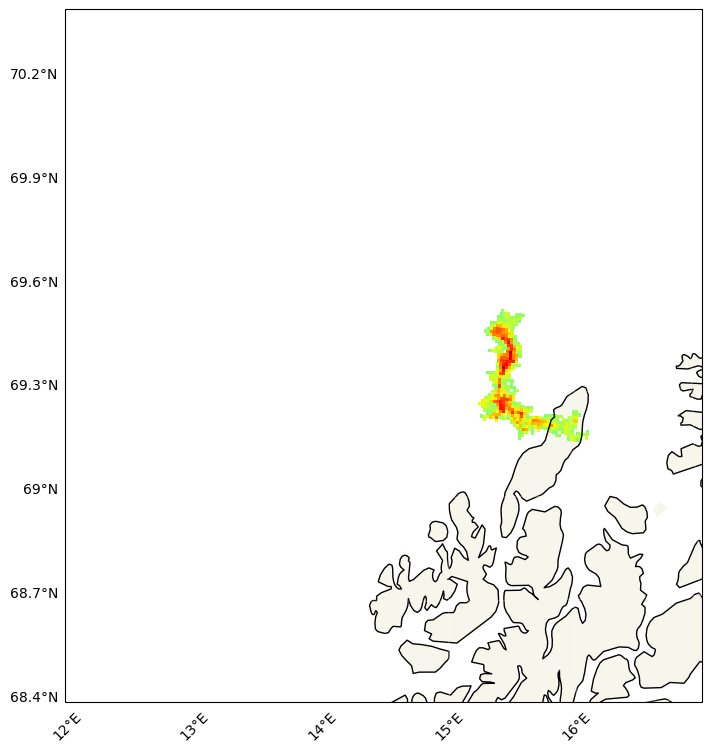

In [107]:
%%time
loop_over = cell1['frame'].values[:1]
cells = cell1['cell'].values[:1]
for cell, i in zip(cells, loop_over):
    latA = 69.141281 #latitude of COMBLE site
    lonA = 15.684166-1 #longitude of COMBLE site -1
    xm, ym = 6,2.75 # extent from center point in lon and lat

    fig, ax = plt.subplots(1,1,figsize=(10,9),subplot_kw={'projection': ccrs.Orthographic(lonA,latA)})
    # xm, ym = 6,2.75 # extent from center point in lon and lat

    # extent = (lonA-xm, lonA+xm, latA-ym, latA+ym) # define extent map
    extent = (lonA-xm+3.3, lonA+xm-3.7, latA-ym+2, latA+ym-1.5) # define extent map
    ax.set_extent(extent) # set extent of map
    ax.coastlines(resolution='10m') # plot coastlines with high resolution: 10m
    # ax.set_facecolor('black')
    ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=0.5)

    # add grid lines
    gl = ax.gridlines(x_inline=False, alpha=0.3, color='white'); gl.bottom_labels=True; gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'}

    

    #############################
    for j in range(0, len(idx)):
    # for j in range(0, len(idx)):
    # for j in range(1, len(idx)):
    
        #change time to moth, day, year, hours and minutes
        dt = masked_values_to_xarray[j]['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 
        # dt = convert['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 


        #  # fill in the place where there is cloud with 1 and place with no cloud to be zero
        # cloud = np.asarray(convert_660[i], dtype='float')
        cloud = np.asarray(convert_alls[j][i], dtype='float')
        invalid_cloud = np.greater(cloud, 0)
        cloud[invalid_cloud] = 1
        invalid_cloud1 = np.less(cloud,1)
        cloud[invalid_cloud1] = np.nan
        
        
        cs=ax.pcolormesh(convert_alls[j]['lon'],
                    convert_alls[j]['lat'], 
                    # cloud*equivalent_reflectivity_factor.values[i],
                    cloud*equivalent_reflectivity_factor.values[i],
                    cmap='jet',
                    transform=ccrs.PlateCarree(),
                    vmin=-20,
                    vmax=40
                    )
    
        # display each id on cell
        frame = cell1[cell1['frame']==i]
        longi = frame['longitude'].values[j]
        lati = frame['latitude'].values[j]
        cell_id = frame['cell'].values[j]
        # fr = frame['frame'].values
        print(frame)
        

        
       
        ####################


        #  #check if area has value of nan
        # if not math.isnan(frame['area($km^2$)'].values[j]):
        #     fontdict={'fontweight': 'black'}
        #     ax.text(longi, lati, cell_id, transform=ccrs.PlateCarree(), fontsize=9, color='black', fontdict=fontdict)

#         # check if area has value of nan
#         if not math.isnan(frame['area($km^2$)'].values[0]):
#             fontdict={'fontweight': 'extra bold'}
#             ax.text(longi, lati+0.1, cloud_id, transform=ccrs.PlateCarree(), fontsize=13, color='white', fontdict=fontdict)


    ax.plot(lonA+1,latA, color='red', marker='*', markersize = 7.5,transform=ccrs.PlateCarree(), order=7) # plot red star at location of Andenes
    # ax.plot(lonA,latA, color='red', marker='*', markersize = 20.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
    ax.set_title(f"Nordic Radar Mosaic: {dt[i]} UTC", fontweight='bold', fontsize=16, pad=11)  # title of figure


    # Add a colorbar axis at the right of the graph
    # cbar_ax = fig.add_axes([0.85, 0.13, 0.047, 0.75]) #lbwh

    cbar_ax = fig.add_axes([0.85, 0.11, 0.047, 0.77]) #lbwh



    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
    cbar.set_label("Reflectivity Factor [dBZ]", fontsize = 15)
    
    
    fig.savefig(f'./../identifying-KAZR-cells//{dt[i]}.png', dpi=300)
    # fig.savefig(f'./all-cells-all-domain//frame{cell} -- {dt[i]}.png', dpi=300)
    # plt.close()



#     dirr = sorted(os.listdir('../identifying-KAZR-cells//'))
#     if f'{dt[i]}.png' in dirr:
#         # print(f'{dt[i]}.png already exist')
#         pass
#         plt.close()
#     else:
#         fig.savefig(f'../identifying-KAZR-cells//{dt[i]}.png', dpi=100)
#         plt.close()
# print('\U0001f600\U0001f600\U0001f600\U0001f600EXECUTION DONE!!!\U0001f600\U0001f600\U0001f600\U0001f600')
# # gc.collect()

In [54]:
idx

array([3192, 3275, 3580, 3855, 3892])

In [55]:
all_idx = cell1['cell'].values
all_long = cell1['longitude'].values
all_lat = cell1['latitude'].values
all_area = cell1['area($km^2$)'].values
all_area

array([ 46.76400915, 394.99667307,   0.99525497, 471.61181959,
        66.66353323, 170.13819373, 254.71930312, 322.37580192,
       402.97248333, 421.87581618, 430.83007889, 479.58570016,
       356.2147848 , 362.16828402, 409.94489445, 213.9216196 ,
       138.29803753])

In [56]:
for lo, la, ce in zip(all_long, all_lat, all_idx):
    print(lo, la, ce)

15.940179824829102 69.20096588134766 3192
15.452092124858115 69.27005073203462 3275
15.994527976927202 69.18294322153761 3192
15.499129635414889 69.24201685667275 3275
15.99736773388343 69.17127139621113 3192
15.550623035120324 69.21530044868577 3275
15.617005035859846 69.17769674360324 3275
15.648055754583794 69.16273670507002 3275
15.714881887445092 69.12326583647788 3580
15.768783666203204 69.09279039581783 3580
15.834736148176962 69.06361563457612 3580
15.86303666332147 69.03591841405273 3580
15.899382112330368 69.01232800852858 3580
15.974544265451518 69.13037692118944 3855
15.93831062101314 68.99093342129467 3580
16.003314855147316 69.11140611517916 3855
14.59744113935912 69.40745617376128 3892


In [63]:
%%time
loop_over = cell1['frame'].values[:]
cells = cell1['cell'].values[:]
for ind, i in enumerate(loop_over):
    latA = 69.141281 #latitude of COMBLE site
    lonA = 15.684166-1 #longitude of COMBLE site -1
    xm, ym = 6,2.75 # extent from center point in lon and lat

    fig, ax = plt.subplots(1,1,figsize=(10,9),subplot_kw={'projection': ccrs.Orthographic(lonA,latA)})
    # xm, ym = 6,2.75 # extent from center point in lon and lat

    # extent = (lonA-xm, lonA+xm, latA-ym, latA+ym) # define extent map
    extent = (lonA-xm+3.3, lonA+xm-3.7, latA-ym+2, latA+ym-1.5) # define extent map
    ax.set_extent(extent) # set extent of map
    ax.coastlines(resolution='10m', color='black') # plot coastlines with high resolution: 10m
    ax.set_facecolor('white')
    ax.add_feature(cfeature.LAND, linewidth=1.5, alpha=0.5)

    # add grid lines
    gl = ax.gridlines(x_inline=False, alpha=0.3, color='white'); gl.bottom_labels=True; gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'}
    

#     cell_id = cell1[cell1['cell'] == all_idx[ind]]
#     latitude = cell_id['latitude'].values
#     longitude = cell_id['longitude'].values
#     cells = cell_id['cell'].values

#     for lo, la, ce, are in zip(all_long, all_lat, all_idx, all_area):
#         ax.text(lo, la, ce, transform=ccrs.PlateCarree(), fontsize=13, color='black')
    
    

    # fontdict={'fontweight': 'extra bold'}
       
    # ax.text(all_long[ind], all_lat[ind], all_idx[ind], transform=ccrs.PlateCarree(), fontsize=13, color='black', fontdict=fontdict)
  
    
    #############################
    for j in range(0, 5):
        # change time to moth, day, year, hours and minutes
        dt = masked_values_to_xarray[j]['time'].dt.strftime('%m-%d-%Y %H:%M').values  ### array 

         # fill in the place where there is cloud with 1 and place with no cloud to be zero
        cloud = np.asarray(convert_alls[j][i], dtype='float')
        invalid_cloud = np.greater(cloud, 0)
        cloud[invalid_cloud] = 1
        invalid_cloud1 = np.less(cloud, 1)
        cloud[invalid_cloud1] = np.nan
        
        
        cs=ax.pcolormesh(convert_alls[j]['lon'],
                    convert_alls[j]['lat'], 
                    # cloud*equivalent_reflectivity_factor.values[i],
                    cloud*equivalent_reflectivity_factor.values[i],
                    cmap='jet',
                    transform=ccrs.PlateCarree(),
                    vmin=-20,
                    vmax=40)
        
    
         # display each id on cell
        frame = cell1[cell1['frame']==i]
        longi = frame['longitude'].values[:]
        lati = frame['latitude'].values[:]
        areaa = frame['area($km^2$)'].values[:]
        cell_id = frame['cell'].values[:]
        cloud_id = frame['cloud_id'].values[:]
        
        #     # check if area has value of nan
        if not math.isnan(frame['area($km^2$)'].values[0]):
            # for lo, la, ce, are in zip(all_long, all_lat, all_idx, all_area):
            for lo, la, ce, are in zip(longi, lati, cell_id, areaa):
                fontdict={'fontweight': 'extra bold'}
                ax.text(lo, la, ce, transform=ccrs.PlateCarree(), fontsize=10, color='black', fontdict=fontdict)
        
    
    ax.plot(lonA+1,latA, color='red', marker='*', markersize = 7.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
# #     # ax.plot(lonA,latA, color='red', marker='*', markersize = 20.5,transform=ccrs.PlateCarree()) # plot red star at location of Andenes
    ax.set_title(f"Nordic Radar Mosaic: {dt[i]} UTC", fontweight='bold', fontsize=16, pad=11)  # title of figure


# #     # Add a colorbar axis at the right of the graph
    # #cbar_ax = fig.add_axes([0.85, 0.13, 0.047, 0.75]) #lbwh

    cbar_ax = fig.add_axes([0.85, 0.11, 0.047, 0.77]) #lbwh



    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
    cbar.set_label("Reflectivity Factor [dBZ]", fontsize = 15)
    
    
    fig.savefig(f'../identifying-KAZR-cells//{dt[i]}.png', dpi=300)
    # fig.savefig(f'./../identifying-KAZR-cells//frame{cell} -- {dt[i]}.png', dpi=300)
    plt.close()



# #     dirr = sorted(os.listdir('./../identifying-KAZR-cells//'))
# #     if f'{dt[i]}.png' in dirr:
# #         # print(f'{dt[i]}.png already exist')
# #         pass
# #         plt.close()
# #     else:
# #         fig.savefig(f'./../identifying-KAZR-cells//{dt[i]}.png', dpi=300)
# #         plt.close()
# # print('\U0001f600\U0001f600\U0001f600\U0001f600EXECUTION DONE!!!\U0001f600\U0001f600\U0001f600\U0001f600')
# # # gc.collect()

CPU times: user 29.4 s, sys: 82.3 ms, total: 29.5 s
Wall time: 30.6 s


In [64]:
%%time
# import glob
# Build GIF
imgs = sorted(glob.glob("../identifying-KAZR-cells/*.png"))
with imageio.get_writer('cell1.gif', mode='I', duration=0.7) as writer:
    for filename in imgs:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

CPU times: user 7.78 s, sys: 17.6 ms, total: 7.8 s
Wall time: 8.04 s


CPU times: user 458 µs, sys: 0 ns, total: 458 µs
Wall time: 463 µs


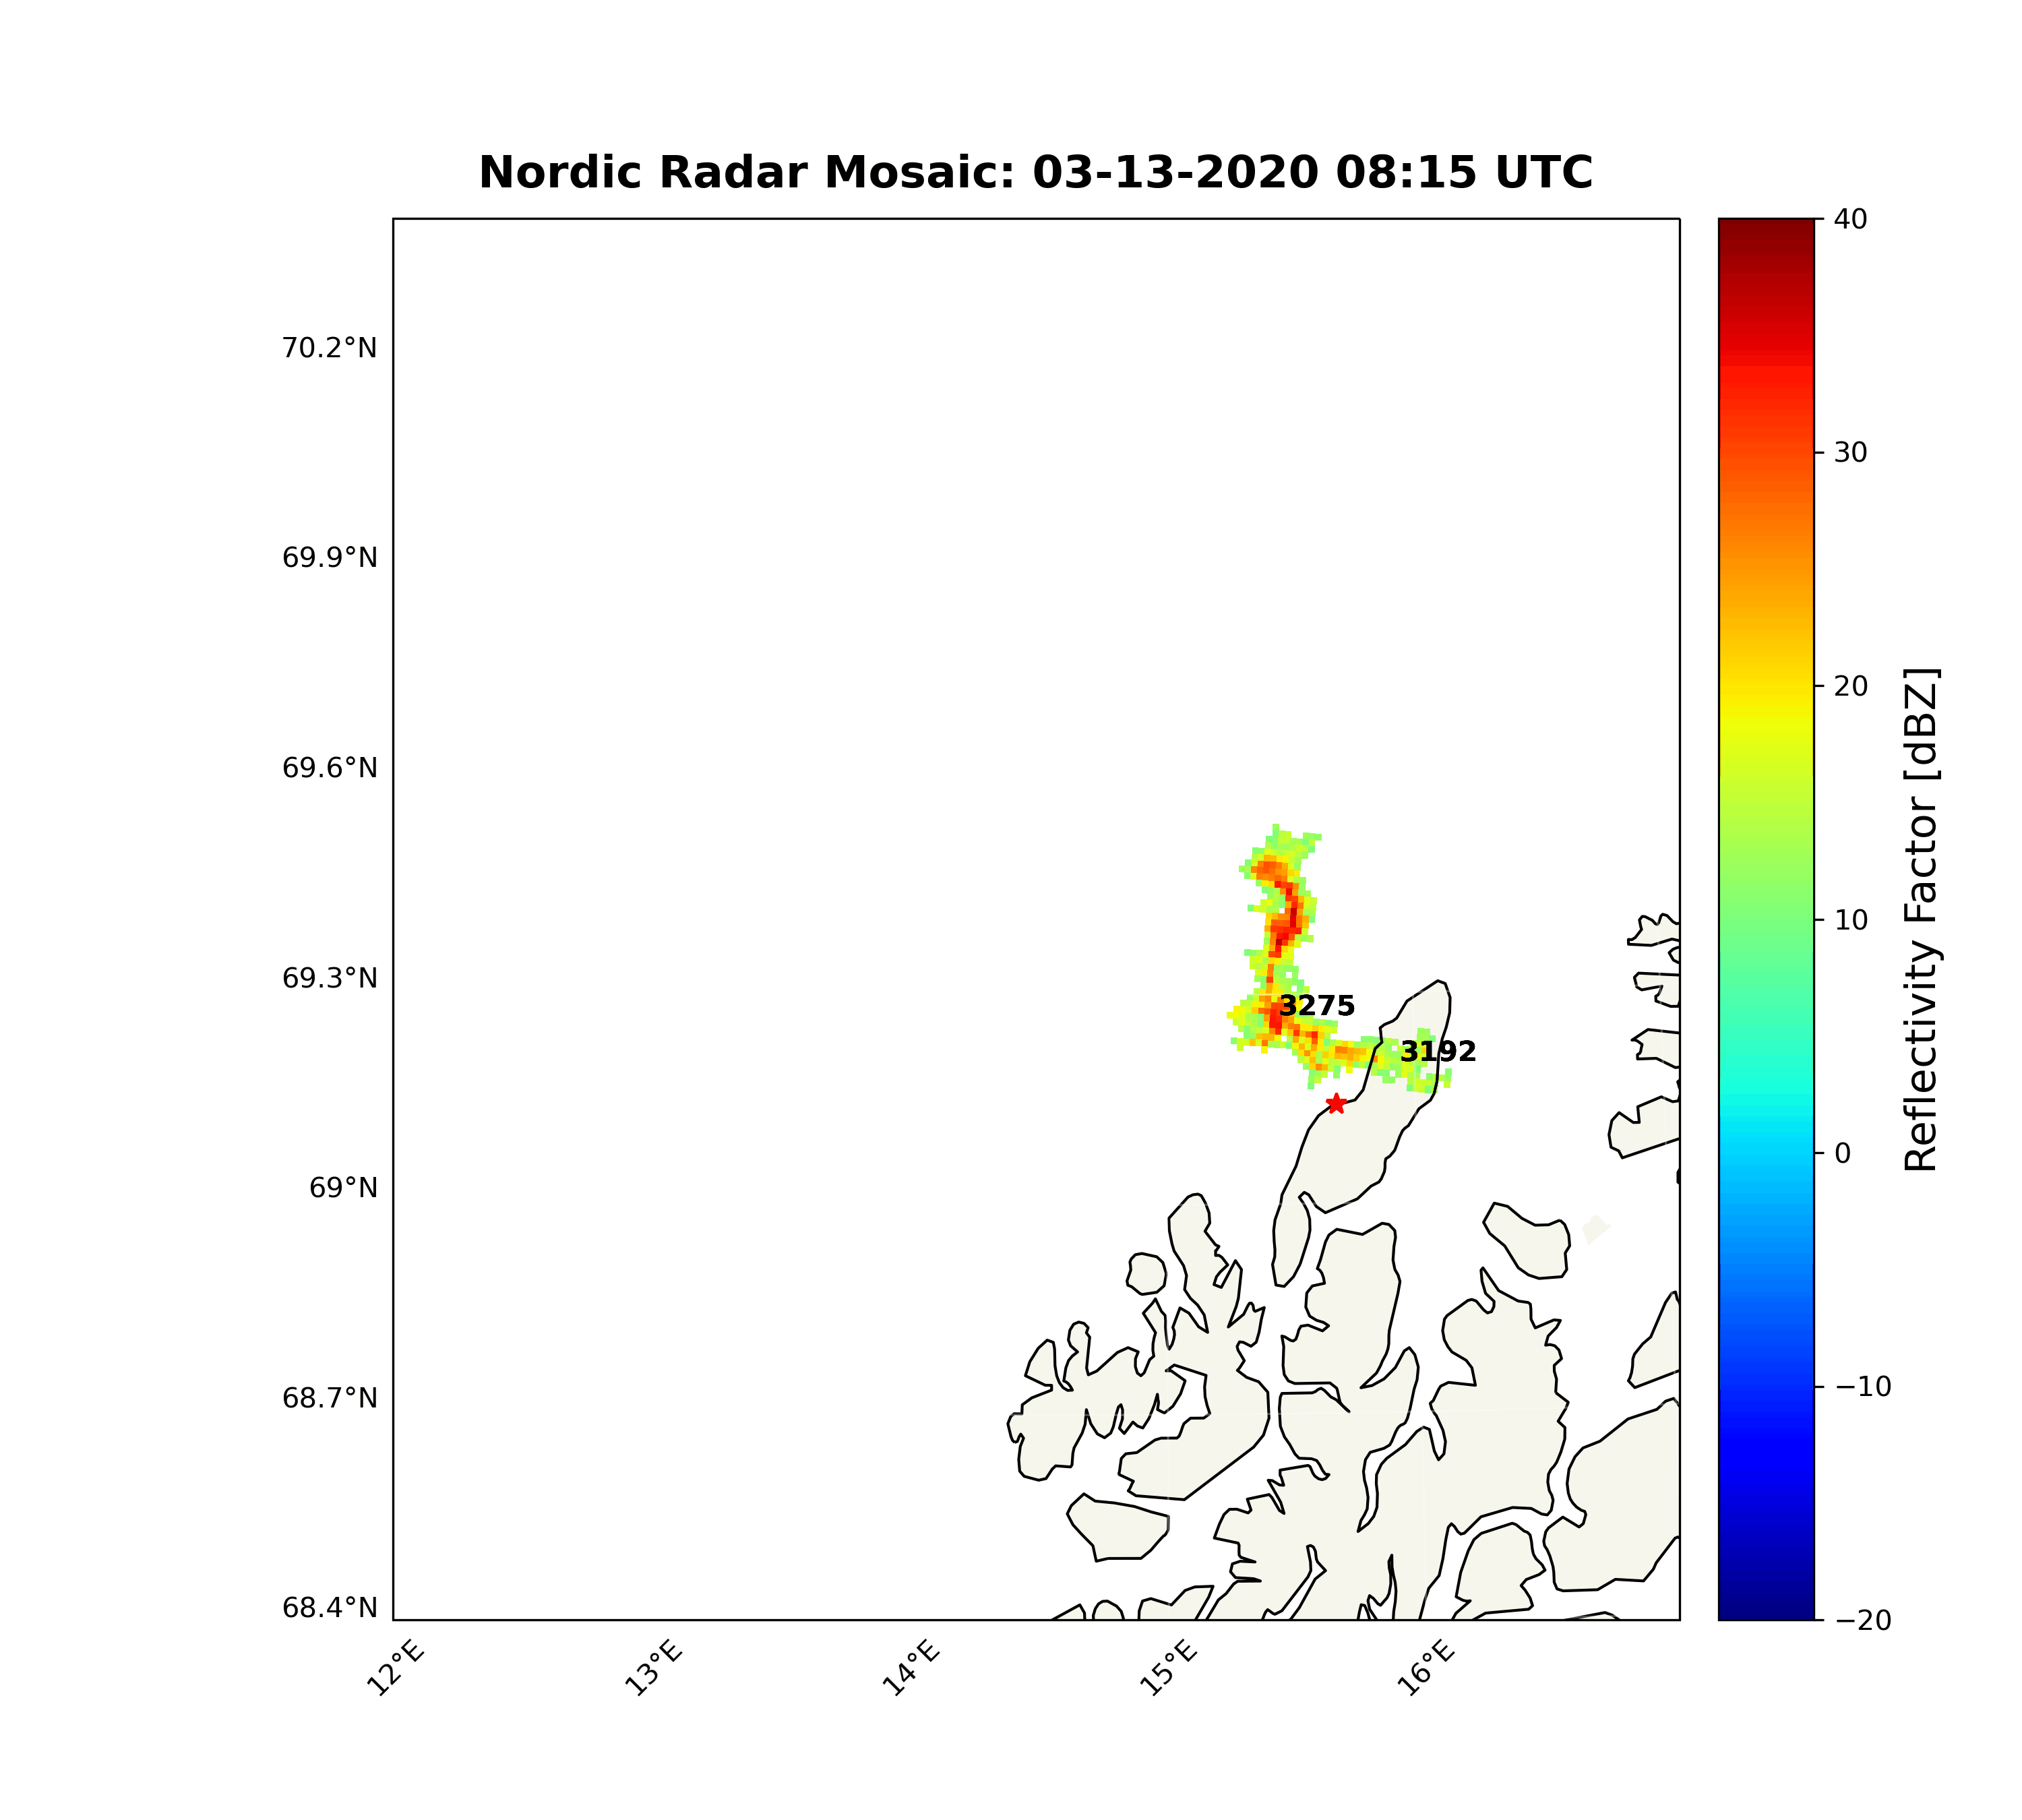

In [65]:
%%time
#Display image
display.Image('cell1.gif', width=700)

# END 